In [32]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
import keras
from sklearn.metrics import confusion_matrix
from keras.metrics import categorical_crossentropy
from keras.metrics import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from keras.preprocessing import image

In [4]:
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
)
validation_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Final defense/Model Run/Model Run//training',
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical'
)

validation = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Final defense/Model Run/Model Run//validation',
    target_size = (224, 224),
    batch_size = 64,
    class_mode = 'categorical'
)

test = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/Final defense/Model Run/Model Run//test',
    target_size = (224, 224),
    batch_size = 64,
    shuffle = False,
    class_mode = 'categorical'
    )

Found 1200 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [44]:
base_model = DenseNet201(weights='imagenet', include_top=False)

In [45]:
DenseNet201.trainable = False

In [46]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

In [47]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, None, None, 3)        0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1/conv[0][0]']    

In [48]:
history = model.fit(
    x = train,
    validation_data = validation,
    epochs = 50
)

Epoch 1/50


KeyboardInterrupt: ignored

In [36]:
# Evaluate the loss and accuracy
loss, accuracy = model.evaluate(test)

# Print the accuracy
print("Accuracy: " + str(accuracy))
# Print the loss
print("Loss: " + str(loss))

5/5 [==============================] - 1s 138ms/step - loss: 0.2861 - accuracy: 0.9067
Accuracy: 0.9066666960716248
Loss: 0.28609713912010193


In [37]:
test.class_indices

{'Anthracnose': 0, 'Cercospora leaf spot': 1, 'Healthy leaf': 2}

In [38]:
import numpy as np
from sklearn import metrics

predictions = model.predict(test)
predicted_classes = np.argmax(predictions, axis = 1)
true_classes = test.classes
class_labels = ['Anthracnose', 'Cercospora leaf spot', 'Healthy leaf']
report = metrics.classification_report(true_classes, predicted_classes, target_names = class_labels)
print(report)

5/5 [==============================] - 4s 160ms/step
                      precision    recall  f1-score   support

         Anthracnose       0.84      0.98      0.91        50
Cercospora leaf spot       0.93      0.86      0.90        50
        Healthy leaf       0.96      0.88      0.92        50

            accuracy                           0.91       150
           macro avg       0.91      0.91      0.91       150
        weighted avg       0.91      0.91      0.91       150



<Axes: >

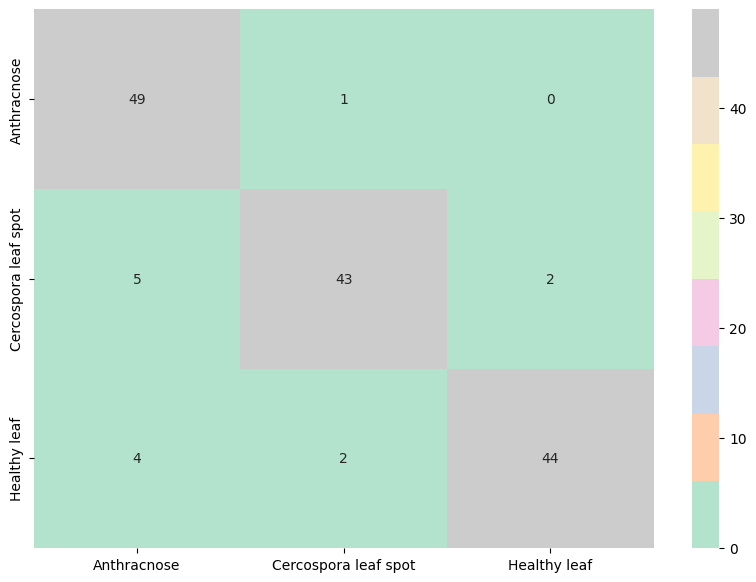

In [39]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_classes, predicted_classes)
df_cm = pd.DataFrame(cm, index = [i for i in ['Anthracnose', 'Cercospora leaf spot', 'Healthy leaf']],
                  columns = [i for i in ['Anthracnose', 'Cercospora leaf spot', 'Healthy leaf']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='d',cmap="Pastel2")

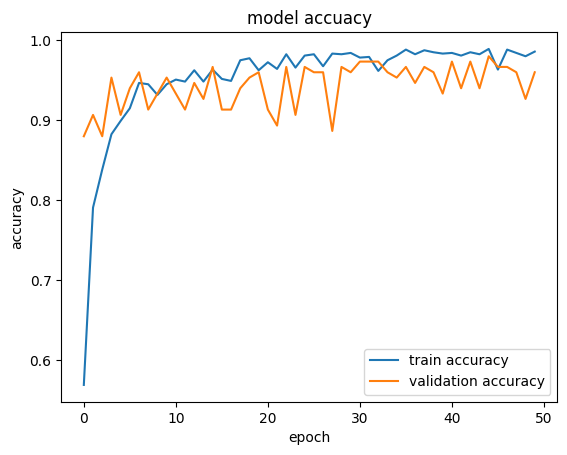

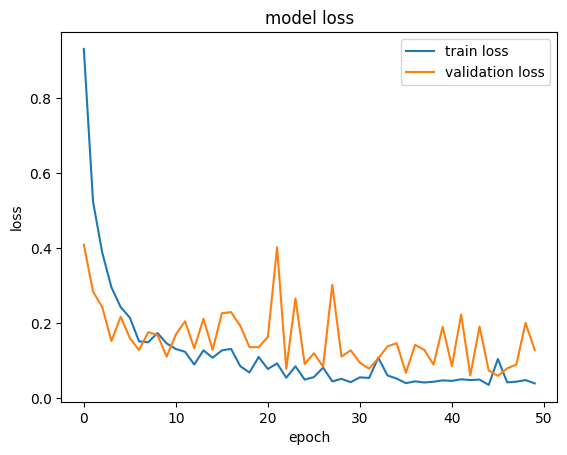

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("model accuacy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.show()

5/5 [==============================] - 1s 155ms/step


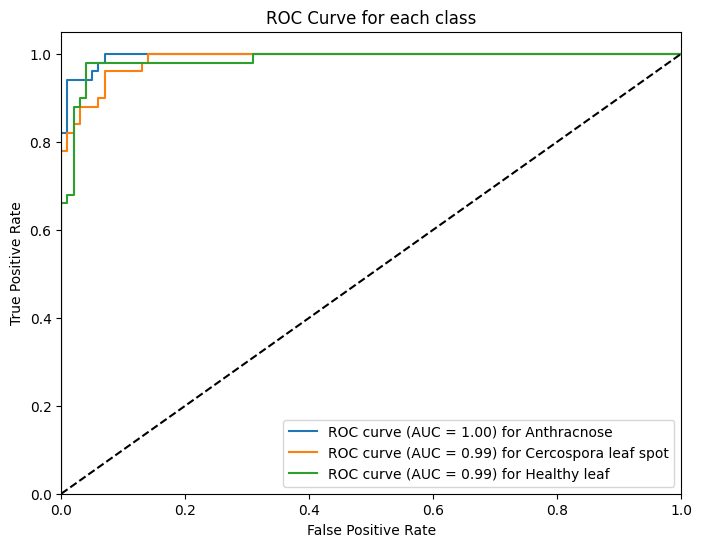

In [41]:
# Compute ROC curve and AUC for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predictions for test data
predictions = model.predict(test)

# Binarize the true labels
true_labels = label_binarize(test.classes, classes=[0, 1, 2])  # Update with the correct number of classes

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (AUC = {roc_auc[i]:.2f}) for {class_labels[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='lower right')
plt.show()

In [42]:
true_labels = label_binarize(test.classes, classes=[0, 1, 2])
predicted_probs = model.predict(test)
predicted_classes = np.argmax(predicted_probs, axis=1)

misclassification_error_rate = np.mean(predicted_classes != test.classes)

print(f'Misclassification Error Rate: {misclassification_error_rate:.2%}')

5/5 [==============================] - 1s 152ms/step
Misclassification Error Rate: 9.33%
